## Reduced Rank Regression

In [1]:
import os
import pickle as pkl
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from utils.helpers import *

# autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
# Define the data path and filename
data_path = os.path.join(os.getcwd(), 'data')
filename = 'ssp585_time_series.pkl'

# Preprocess the data
data, nan_mask = preprocess_data(data_path, filename)

Loading data from ssp585_time_series.pkl
Data loaded successfully.
Filtering data...


100%|██████████| 72/72 [00:00<00:00, 67847.65it/s]


Data filtered. Kept 34 models
Creating NaN mask...


100%|██████████| 34/34 [00:01<00:00, 20.25it/s]


NaN mask created.
Masking out NaN values...


100%|██████████| 34/34 [00:01<00:00, 21.73it/s]


NaN values masked out.
Reshaping data...


100%|██████████| 34/34 [00:03<00:00,  9.45it/s]


Data reshaped.
Adding the forced response to the data...


100%|██████████| 34/34 [00:05<00:00,  6.49it/s]


Forced response added.
Removing NaN values from the grid...


100%|██████████| 34/34 [00:01<00:00, 26.26it/s]


NaN values removed.


In [3]:
# Define the lambda values to test
lambdas = [0.01, 0.1, 1, 10]

In [8]:
# Only keep 7 random models for the sake of time
random.seed(42)
models = random.sample(list(data.keys()), 7)
subset_data = {model: data[model] for model in models}
print(f"Models kept to test the pipeline: {models}")

Models kept to test the pipeline: ['GISS-E2-2-G', 'EC-Earth3', 'ACCESS-ESM1-5', 'CESM2-FV2', 'NorCPM1', 'CESM2', 'CAS-ESM2-0']


In [17]:
# Perform leave-one-out cross-validation
mse_distributions = loo_cross_validation(subset_data, lambdas, rank=15)

  0%|          | 0/7 [00:00<?, ?it/s]

Normalizing data...


100%|██████████| 1/1 [00:00<00:00, 23.29it/s]


Data normalization completed.
Pooling data...


100%|██████████| 6/6 [00:00<00:00, 154391.56it/s]


Data pooled.
Performing leave-one-out cross-validation for model: GISS-E2-2-G
Fitting OLS...
RRR completed.
Fitting OLS...
RRR completed.
Fitting OLS...
RRR completed.
Fitting OLS...
RRR completed.


 14%|█▍        | 1/7 [03:27<20:47, 207.97s/it]

Normalizing data...


100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


Data normalization completed.
Pooling data...


100%|██████████| 6/6 [00:00<00:00, 181049.09it/s]


Data pooled.
Performing leave-one-out cross-validation for model: EC-Earth3
Fitting OLS...
RRR completed.
Fitting OLS...
RRR completed.
Fitting OLS...
RRR completed.
Fitting OLS...
RRR completed.


 29%|██▊       | 2/7 [06:44<16:46, 201.24s/it]

Normalizing data...


100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


Data normalization completed.
Pooling data...


100%|██████████| 6/6 [00:00<00:00, 199728.76it/s]


Data pooled.
Performing leave-one-out cross-validation for model: ACCESS-ESM1-5
Fitting OLS...
RRR completed.
Fitting OLS...
RRR completed.
Fitting OLS...
RRR completed.
Fitting OLS...
RRR completed.


 43%|████▎     | 3/7 [09:48<12:52, 193.17s/it]

Normalizing data...


100%|██████████| 1/1 [00:00<00:00, 39.31it/s]


Data normalization completed.
Pooling data...


100%|██████████| 6/6 [00:00<00:00, 187804.66it/s]


Data pooled.
Performing leave-one-out cross-validation for model: CESM2-FV2
Fitting OLS...
RRR completed.
Fitting OLS...
RRR completed.
Fitting OLS...
RRR completed.
Fitting OLS...


 57%|█████▋    | 4/7 [13:20<10:02, 200.95s/it]

RRR completed.
Normalizing data...


100%|██████████| 1/1 [00:00<00:00,  6.42it/s]


Data normalization completed.
Pooling data...


100%|██████████| 6/6 [00:00<00:00, 29537.35it/s]


Data pooled.
Performing leave-one-out cross-validation for model: NorCPM1
Fitting OLS...
RRR completed.
Fitting OLS...
RRR completed.
Fitting OLS...
RRR completed.
Fitting OLS...
RRR completed.


 71%|███████▏  | 5/7 [16:31<06:34, 197.26s/it]

Normalizing data...


100%|██████████| 1/1 [00:00<00:00, 18.97it/s]


Data normalization completed.
Pooling data...


100%|██████████| 6/6 [00:00<00:00, 167772.16it/s]


Data pooled.
Performing leave-one-out cross-validation for model: CESM2
Fitting OLS...
RRR completed.
Fitting OLS...
RRR completed.
Fitting OLS...
RRR completed.
Fitting OLS...
RRR completed.


 86%|████████▌ | 6/7 [19:56<03:19, 199.92s/it]

Normalizing data...


100%|██████████| 1/1 [00:00<00:00, 41.13it/s]


Data normalization completed.
Pooling data...


100%|██████████| 6/6 [00:00<00:00, 133152.51it/s]


Data pooled.
Performing leave-one-out cross-validation for model: CAS-ESM2-0
Fitting OLS...
RRR completed.
Fitting OLS...
RRR completed.
Fitting OLS...
RRR completed.
Fitting OLS...


100%|██████████| 7/7 [23:27<00:00, 201.09s/it]

RRR completed.


/var/folders/9v/q6t68ds12f9c4dgn9gnwzrmr0000gn/T/ipykernel_13390/3700118675.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, vert=True, patch_artist=True, labels=labels)


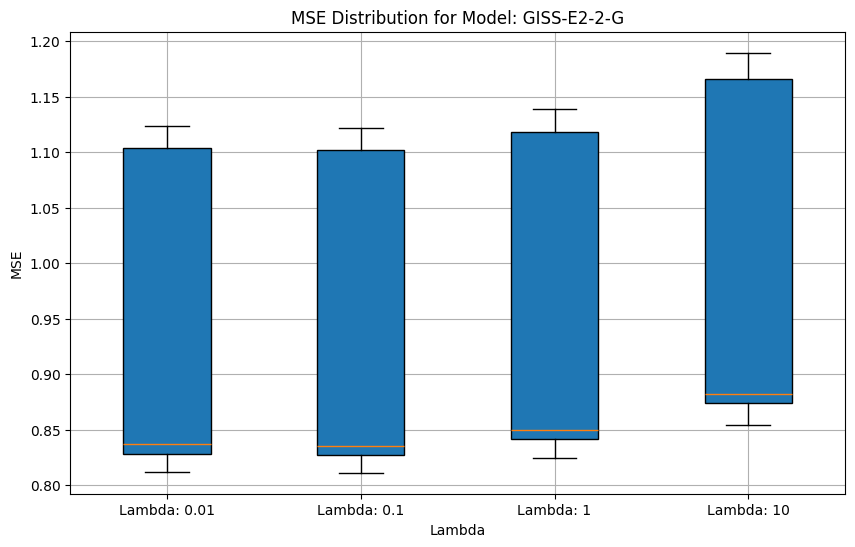

/var/folders/9v/q6t68ds12f9c4dgn9gnwzrmr0000gn/T/ipykernel_13390/3700118675.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, vert=True, patch_artist=True, labels=labels)


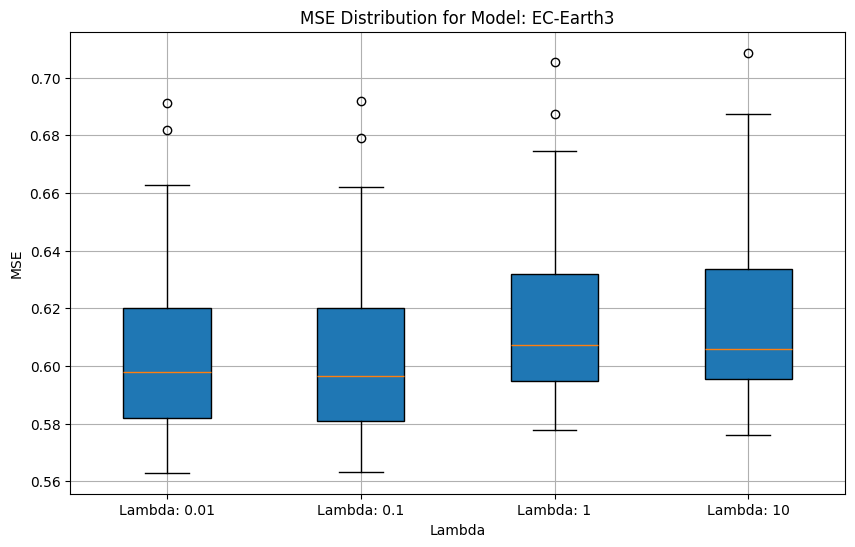

/var/folders/9v/q6t68ds12f9c4dgn9gnwzrmr0000gn/T/ipykernel_13390/3700118675.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, vert=True, patch_artist=True, labels=labels)


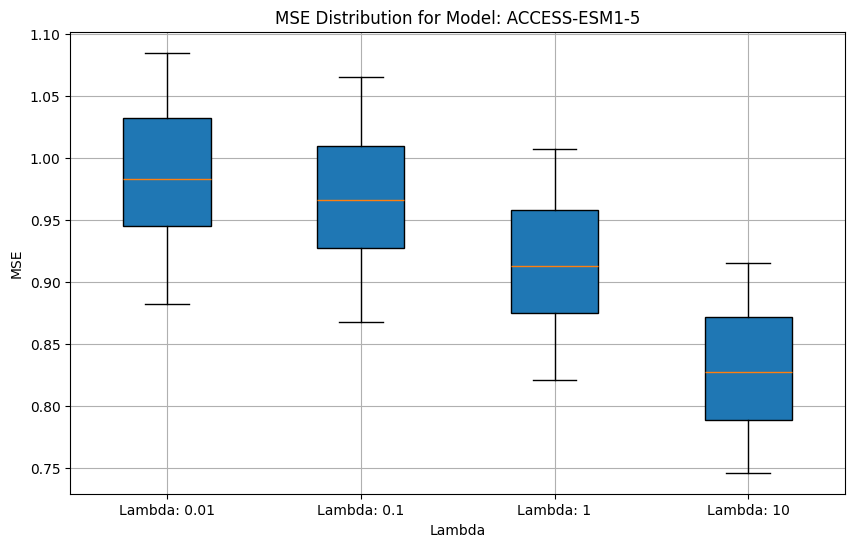

/var/folders/9v/q6t68ds12f9c4dgn9gnwzrmr0000gn/T/ipykernel_13390/3700118675.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, vert=True, patch_artist=True, labels=labels)


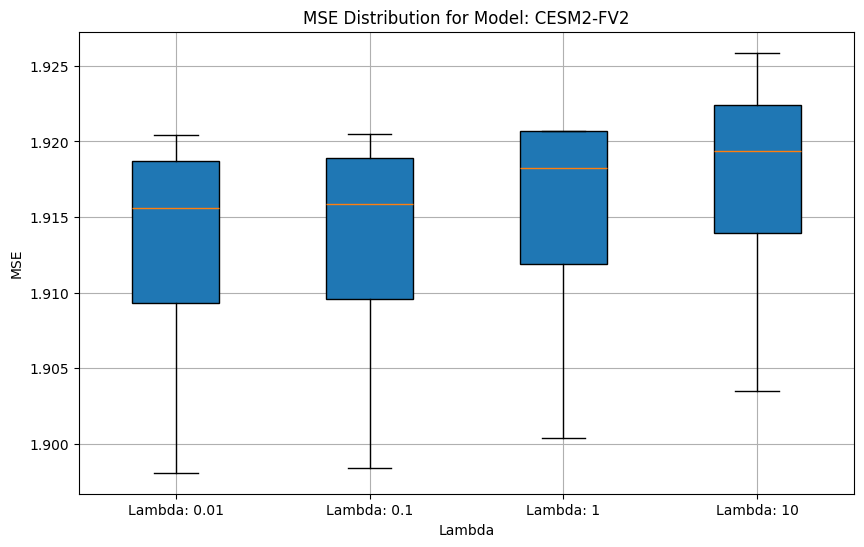

/var/folders/9v/q6t68ds12f9c4dgn9gnwzrmr0000gn/T/ipykernel_13390/3700118675.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, vert=True, patch_artist=True, labels=labels)


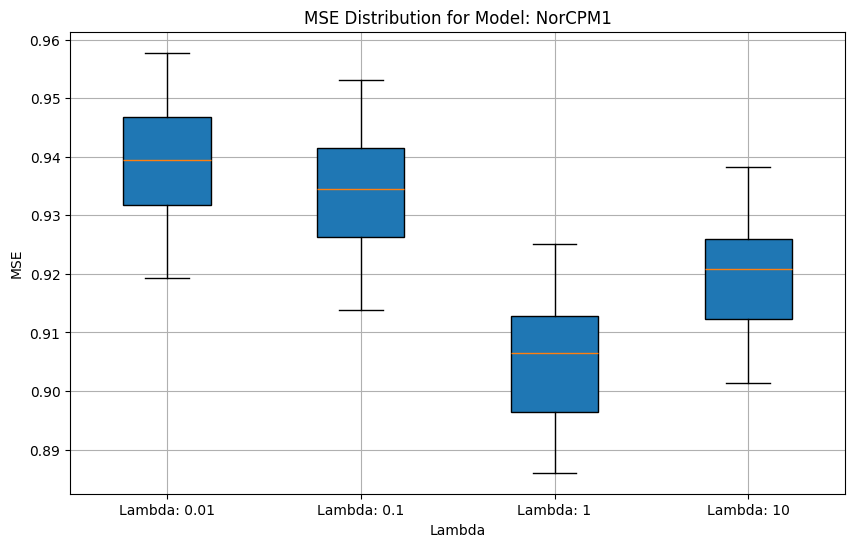

/var/folders/9v/q6t68ds12f9c4dgn9gnwzrmr0000gn/T/ipykernel_13390/3700118675.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, vert=True, patch_artist=True, labels=labels)


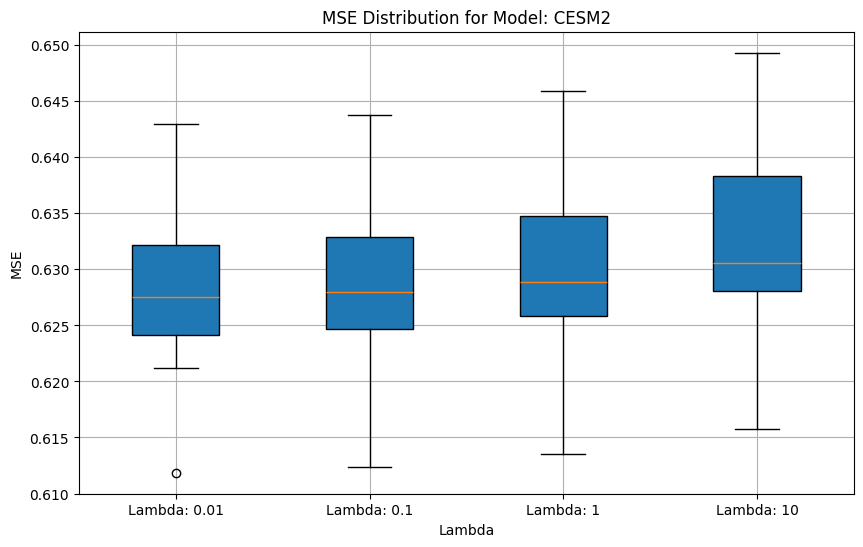

/var/folders/9v/q6t68ds12f9c4dgn9gnwzrmr0000gn/T/ipykernel_13390/3700118675.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, vert=True, patch_artist=True, labels=labels)


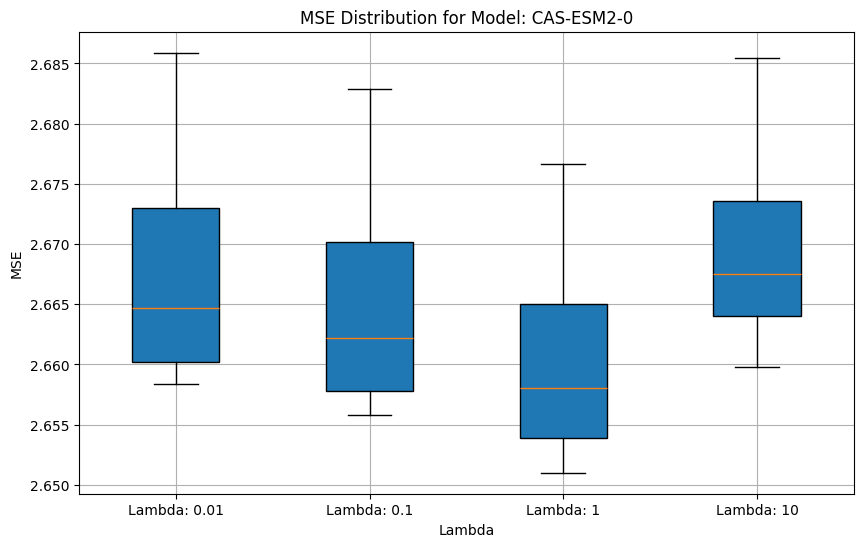

Best lambda overall: 10, MSE: 0.9053


In [20]:
# Plot the MSE distributions for each model using boxplots
for model in models:
    plt.figure(figsize=(10, 6))
    data_to_plot = []
    labels = []
    for lambda_ in lambdas:
        if model in mse_distributions[lambda_]:
            mse_values = mse_distributions[lambda_][model]
            data_to_plot.append(mse_values)
            labels.append(f'Lambda: {lambda_}')
    plt.boxplot(data_to_plot, vert=True, patch_artist=True, labels=labels)
    plt.xlabel('Lambda')
    plt.ylabel('MSE')
    plt.title(f'MSE Distribution for Model: {model}')
    plt.grid(True)
    plt.show()

# Calculate the best lambda overall
best_lambda = None
best_mse = float('inf')
for lambda_, model_mse in mse_distributions.items():
    all_mse_values = [mse for mse_list in model_mse.values() for mse in mse_list]
    mean_mse = np.mean(all_mse_values)
    if mean_mse < best_mse:
        best_mse = mean_mse
        best_lambda = lambda_

print(f"Best lambda overall: {best_lambda}, MSE: {best_mse:.4f}")